In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import json

In [2]:
class analise():
    def juntaDados(self,file):
        self.dados_DF=pd.read_csv(file[0],sep=";",index_col=['data'],parse_dates=['data'])
        for i in range(1,len(file)):
            dado=pd.read_csv(file[i],sep=";",index_col=['data'],parse_dates=['data'])
            self.dados_DF=pd.concat([dado,self.dados_DF])
    
        self.df_states=self.dados_DF[(~self.dados_DF["estado"].isna()) & (self.dados_DF["codmun"].isna())] #selecionando os dados dos estados
        self.df_states=self.df_states[["estado","casosAcumulado","casosNovos","obitosAcumulado","obitosNovos"]]
        self.df_states.to_csv("df_states.csv") # gerando um cvs com esses dados

        self.df_brasil=self.dados_DF[self.dados_DF["regiao"]=="Brasil"] #selecionando os dados so do brasil
        self.df_brasil=self.df_brasil[["casosAcumulado","casosNovos","obitosAcumulado","obitosNovos"]]
        self.df_brasil.to_csv("df_brasil.csv")

    def casosDia(self): 
        self.casosDia_df=self.df_brasil[['casosNovos']] #formando um outro dataframe so com as datas e com os casos novos
        self.roll=self.casosDia_df.rolling(window=15) #determinando a media movel
        self.rolling_mean=self.roll.mean()
        self.rolling_mean=self.rolling_mean.fillna(0)

        self.casosDia_df.plot(color='blue',lw=0.5) # plotando os graficos
        plt.title("casos novos diarios")
        self.rolling_mean.plot(linestyle="-.",color='red',lw=0.5)
        plt.title('media movel dos casos diarios')
        plt.show()

    def mortesDia(self):
        self.obitosDia_df=self.df_brasil[['obitosNovos']]
        self.roll=self.obitosDia_df.rolling(window=15)
        self.rolling_mean=self.roll.mean()
        self.rolling_mean=self.rolling_mean.fillna(0)
        
        self.obitosDia_df.plot(color='blue',lw=0.5)
        plt.title("obtos novos diarios")
        self.rolling_mean.plot(linestyle="-.",color='red',lw=0.5)
        plt.title('media movel dos obitos diarios')
        plt.show()

    def sazonalidas(self, data):
        for i in range(2020,2023,1):
            data[(data.index.year>=i)&(data.index.year<=i+1)].diff().plot()  

    def taxaMortalidade(self):
        self.casosObitosEs=self.df_states[["estado","casosNovos","obitosNovos"]].groupby("estado").sum()
        self.taxa_df=(self.casosObitosEs["obitosNovos"]/self.casosObitosEs["casosNovos"]).to_frame()
        self.taxa_df=self.taxa_df.rename(columns={0:'taxaMortalidade'})
        self.casosObitosEs.loc[:,"taxaMortalidade"]=self.taxa_df[["taxaMortalidade"]]
        self.casosObitosEs = self.casosObitosEs.rename(columns={'casosNovos': 'casos acumulados','obitosNovos':"obitos acumulados"})



In [3]:
report=analise()

report.juntaDados(["HIST_PAINEL_COVIDBR_2022_Parte1_04mar2022.csv","HIST_PAINEL_COVIDBR_2021_Parte2_04mar2022.csv","HIST_PAINEL_COVIDBR_2021_Parte1_04mar2022.csv",
                    "HIST_PAINEL_COVIDBR_2020_Parte2_04mar2022.csv","HIST_PAINEL_COVIDBR_2020_Parte1_04mar2022.csv"])

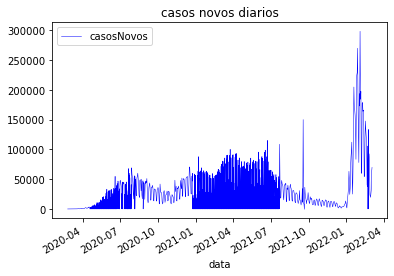

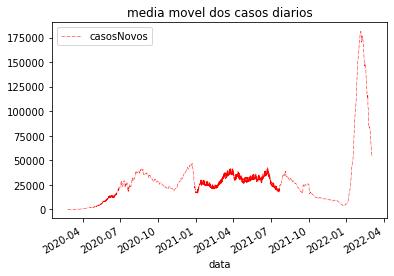

In [4]:
report.casosDia()

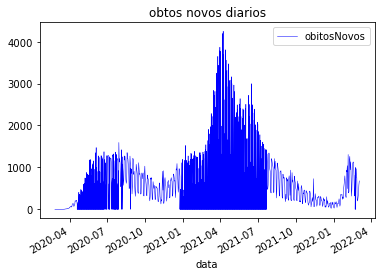

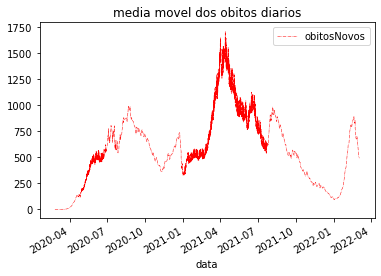

In [5]:
report.mortesDia()

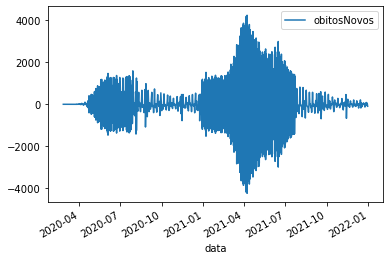

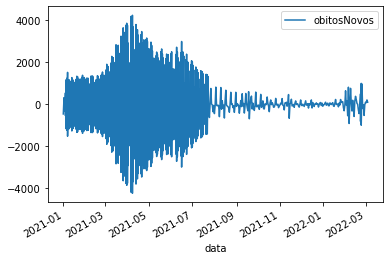

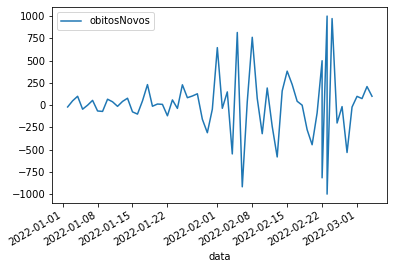

In [6]:
#representação da sazonalidade dos obitos,no periode de 2020-2022, 2021-2022,2022-2022
report.sazonalidas(report.obitosDia_df)

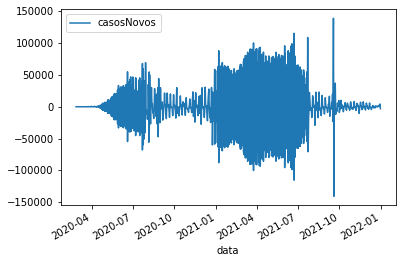

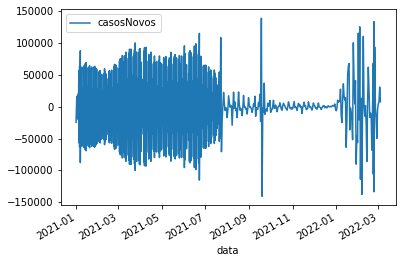

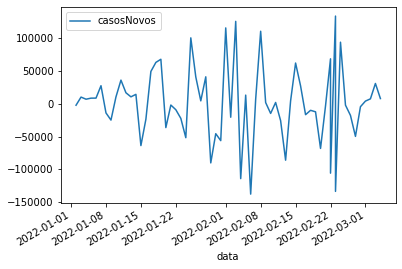

In [7]:
#representação da sazonalidade dos casos diarios,no periode de 2020-2022, 2021-2022,2022-2022
report.sazonalidas(report.casosDia_df)

In [8]:
report.taxaMortalidade()
report.casosObitosEs

,casos acumulados,obitos acumulados,taxaMortalidade
estado,,,
AC,122060,1979,0.016213
AL,292568,6726,0.022990
AM,574304,14124,0.024593
AP,160128,2109,0.013171
BA,1507386,29336,0.019462
CE,1229820,26385,0.021454
DF,685097,11461,0.016729
ES,1025714,14166,0.013811
GO,1178585,25807,0.021897


In [9]:
#o arquivo json mostra as latitudes e longitudes das fronteiras de cada estado do brasil
brasil_states=json.load(open("geojson/brasil_geo.json","r"))
brasil_states["features"][0].keys()

df_states = pd.read_csv("df_states.csv")

df_states_ = df_states[df_states["data"] == "2022-03-04"]
select_columns = {"casosAcumulado": "Casos Acumulados", 
                "casosNovos": "Novos Casos", 
                "obitosAcumulado": "Óbitos Totais",
                "obitosNovos": "Óbitos por dia"}


app = dash.Dash(__name__, external_stylesheets=[dbc.themes.SLATE])

fig = px.choropleth_mapbox(df_states_, locations="estado",
    geojson=brasil_states, center={"lat": -16.95, "lon": -47.78},
    zoom=4, color="casosNovos", color_continuous_scale="Redor", opacity=0.4,
    hover_data={"casosAcumulado": True,"obitosAcumulado":True, "casosNovos": True, "obitosNovos": True, "estado": True}
    )
fig.update_layout(
                paper_bgcolor="#242424",
                mapbox_style="carto-darkmatter",
                autosize=True,
                margin=go.layout.Margin(l=0, r=0, t=0, b=0),
                showlegend=False,)
df_data = df_states[df_states["estado"] == "RO"]

fig2 = go.Figure(layout={"template":"plotly_dark"})
fig2.add_trace(go.Scatter(x=df_data["data"], y=df_data["casosAcumulado"]))
fig2.update_layout(
    paper_bgcolor="#242424",
    plot_bgcolor="#242424",
    autosize=True,
    margin=dict(l=10, r=10, b=10, t=10),
    )

app.layout=dbc.Container(
        dbc.Row([
            dbc.Col([
                dcc.Graph(id="croropleth-map",figure=fig)
            ])
        ])
)

if __name__ == "__main__":
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
